In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
os.chdir("E://PycharmProjects//baidu//code")

In [3]:
train_queries = pd.read_csv('../data/data_set_phase2/train_queries.csv', parse_dates=['req_time'])
test_queries = pd.read_csv('../data/data_set_phase2/test_queries.csv', parse_dates=['req_time'])
train_plans = pd.read_csv('../data/data_set_phase2/train_plans.csv')
test_plans = pd.read_csv('../data/data_set_phase2/test_plans.csv')

train_click = pd.read_csv('../data/data_set_phase2/train_clicks.csv')

In [4]:
def get_candidate_set(data):
    """
    获取推荐列表display里的信息
    """
    sids = []
    distance = []
    price = []
    eta = []
    mins = []
    mode = []
    ranks = []
    for i in data[["sid", "plans"]].values:
        plan_list = eval(i[1])
        for s in plan_list:
            sids.append(i[0])
            distance.append(s["distance"])
            if s["price"] == "":
                price.append(0)
            else:
                price.append(s["price"])
            eta.append(s["eta"])
            mins.append(s["eta"] // 60)
            mode.append(s["transport_mode"])
            ranks.append(plan_list.index(s))
    res = pd.DataFrame(
        {"sid": sids, "distance": distance, "price": price, "eta": eta, "minutes": mins, "mode": mode, "display_rank": ranks})
    print("Candidate done!")
    return res

display = get_candidate_set(train_plans)

Candidate done!


In [5]:
display = display.merge(train_click, on='sid', how='left')
display.head()

,sid,distance,price,eta,minutes,mode,display_rank,click_time,click_mode
0,955169,10148,600,2927,48,7,0,2018-10-20 20:24:02,7.0
1,955169,9663,0,1398,23,3,1,2018-10-20 20:24:02,7.0
2,955169,9663,3700,1518,25,4,2,2018-10-20 20:24:02,7.0
3,955169,9809,400,2383,39,9,3,2018-10-20 20:24:02,7.0
4,955169,9774,0,2951,49,6,4,2018-10-20 20:24:02,7.0


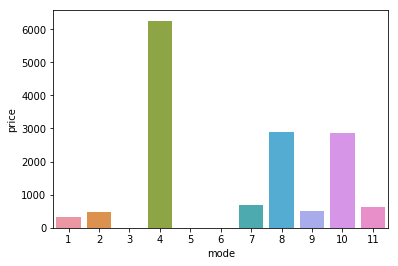

In [6]:
price = display.groupby('mode', as_index=False)['price'].agg('mean')
sns.barplot(x='mode', y='price', data=price)
plt.show()

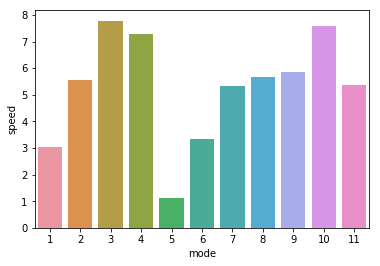

In [7]:
display['speed'] = display['distance'].div(display['eta'])
speed = display.groupby('mode', as_index=False)['speed'].agg('mean')
sns.barplot(x='mode', y='speed', data=speed)
plt.show()

可以看出3,5,6价格都是0,5的速度最慢，应该是步行，其次是6，应该是骑车，3应该是自驾。2可能是公交和地铁，因为它的速度很快，但是价格较低。每种交通方式的选择次数也不一样，如下图所示。

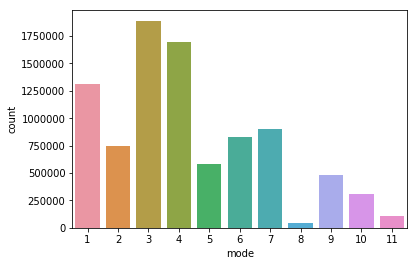

In [8]:
nums = display.groupby('mode', as_index=False)['speed'].agg({'count': 'count'})
sns.barplot(x='mode', y='count', data=nums)
plt.show()

再来看看OD (origin - destination) 之间的距离对于交通方式的选择有没有影响。

In [9]:
import numpy as np


def haversine(lat1, lng1, lat2, lng2):
    """
    function to calculate haversine distance between two co-ordinates
    """
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    earth_radius = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * earth_radius * np.arcsin(np.sqrt(d))
    return h


def manhattan(lat1, lng1, lat2, lng2):
    """
    function to calculate manhatten distance between pick_drop
    """
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b


queries_clicks = train_queries.merge(train_click, on="sid", how="left")

queries_clicks = queries_clicks.sort_values("req_time").reset_index(drop=True)
queries_clicks["od"] = queries_clicks["o"] + queries_clicks["d"]
queries_clicks["hour"] = queries_clicks.req_time.dt.hour

manhattan_distance = []
tmp = queries_clicks[['o', 'd']]
for i in tmp.values:
    lat1, lon1 = eval(i[0])[1], eval(i[0])[0]
    lat2, lon2 = eval(i[1])[1], eval(i[1])[0]
    manhattan_distance.append(manhattan(float(lat1), float(lon1), float(lat2), float(lon2)))
queries_clicks.loc[:, 'manhattan'] = manhattan_distance

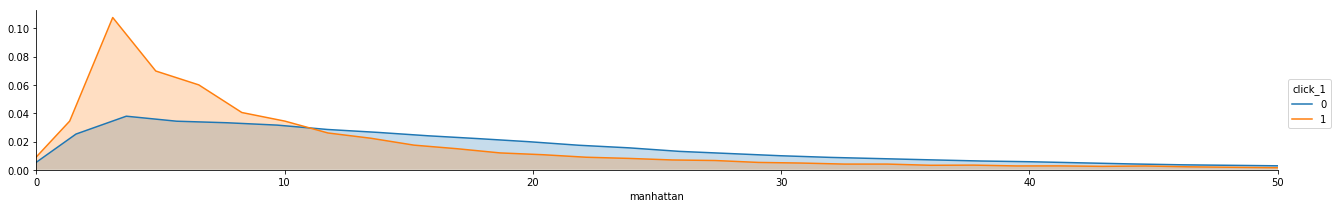

In [10]:
queries_clicks["click_1"] = queries_clicks["click_mode"].apply(lambda x: 1 if x == 1 else 0)
a = sns.FacetGrid(queries_clicks, hue="click_1", aspect=6)
a.map(sns.kdeplot, 'manhattan', shade=True)
a.set(xlim=(0, 50))
a.add_legend()
del queries_clicks["click_1"]

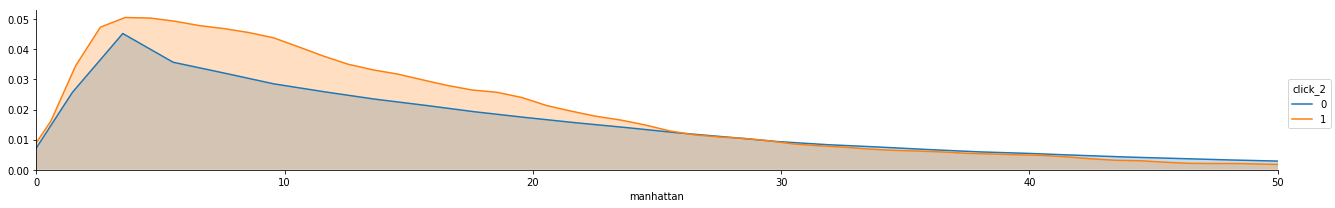

In [11]:
queries_clicks["click_2"] = queries_clicks["click_mode"].apply(lambda x: 1 if x == 2 else 0)
a = sns.FacetGrid(queries_clicks, hue="click_2", aspect=6)
a.map(sns.kdeplot, 'manhattan', shade=True)
a.set(xlim=(0, 50))
a.add_legend()
del queries_clicks["click_2"]

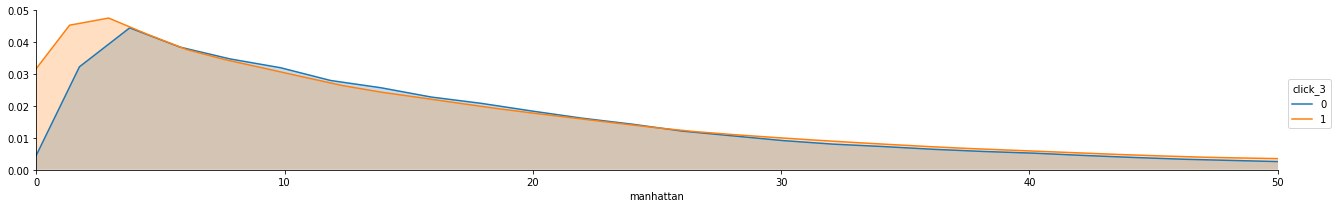

In [12]:
queries_clicks["click_3"] = queries_clicks["click_mode"].apply(lambda x: 1 if x == 3 else 0)
a = sns.FacetGrid(queries_clicks, hue="click_3", aspect=6)
a.map(sns.kdeplot, 'manhattan', shade=True)
a.set(xlim=(0, 50))
a.add_legend()
del queries_clicks["click_3"]

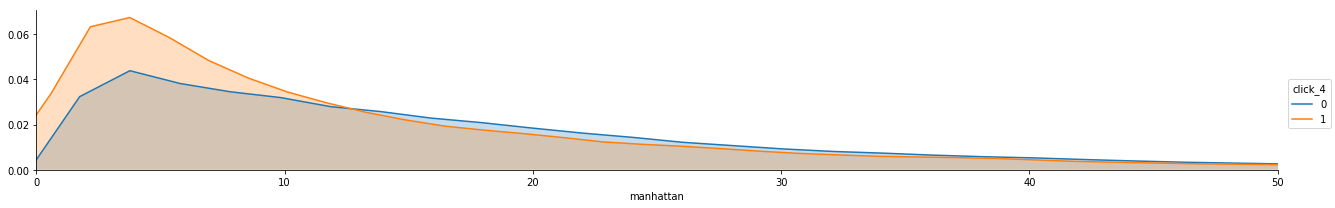

In [13]:
queries_clicks["click_4"] = queries_clicks["click_mode"].apply(lambda x: 1 if x == 4 else 0)
a = sns.FacetGrid(queries_clicks, hue="click_4", aspect=6)
a.map(sns.kdeplot, 'manhattan', shade=True)
a.set(xlim=(0, 50))
a.add_legend()
del queries_clicks["click_4"]

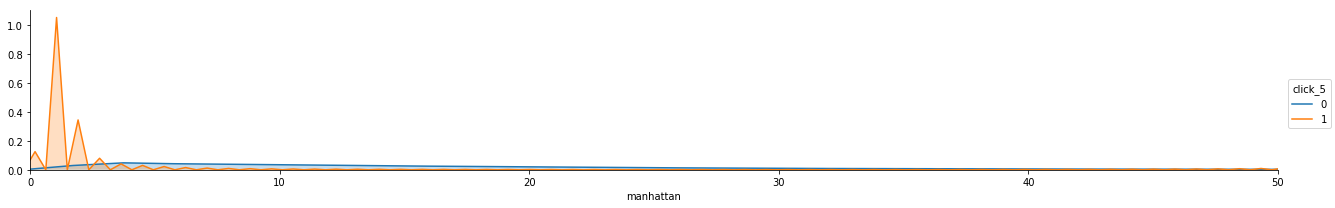

In [14]:
queries_clicks["click_5"] = queries_clicks["click_mode"].apply(lambda x: 1 if x == 5 else 0)
a = sns.FacetGrid(queries_clicks, hue="click_5", aspect=6)
a.map(sns.kdeplot, 'manhattan', shade=True)
a.set(xlim=(0, 50))
a.add_legend()
del queries_clicks["click_5"]

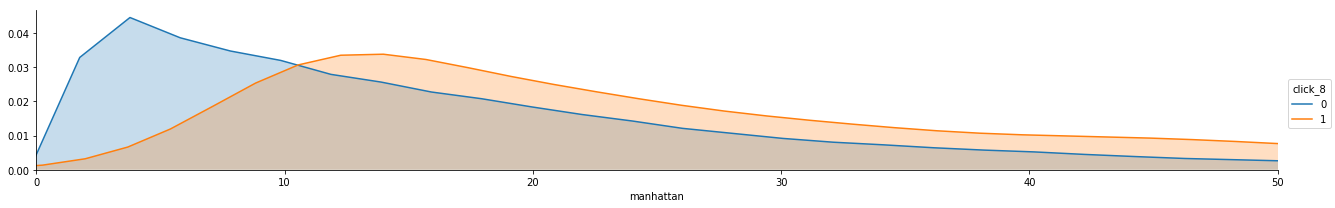

In [15]:
queries_clicks["click_8"] = queries_clicks["click_mode"].apply(lambda x: 1 if x == 8 else 0)
a = sns.FacetGrid(queries_clicks, hue="click_8", aspect=6)
a.map(sns.kdeplot, 'manhattan', shade=True)
a.set(xlim=(0, 50))
a.add_legend()
del queries_clicks["click_8"]

往后不一一看了，通过这个我们可以对距离进行分箱，用信息价值IV计算下分箱的效果。

In [16]:
def dist_part(x):
    if x == 0:
        return 0
    elif 0 < x <= 1:
        return 1
    elif 1 < x <= 3:
        return 2
    elif 3 < x <= 5:
        return 3
    elif 5 < x <= 8:
        return 4
    elif 8 < x <= 10:
        return 5
    elif 10 < x <= 15:
        return 6
    elif 15 < x <= 25:
        return 7
    elif 25 < x <= 50:
        return 8
    elif x > 50:
        return 9
    
queries_clicks["dist_part"] = queries_clicks["manhattan"].apply(lambda x: dist_part(x))
queries_clicks["click_4"] = queries_clicks["click_mode"].apply(lambda x: 1 if x == 4 else 0)

In [17]:
woe = queries_clicks.groupby("dist_part", as_index=False)["click_4"].agg({"response": "sum", "nums": "count"})
woe["no_response"] = woe["nums"] - woe["response"]
woe["response_ratio"] = woe["response"] / queries_clicks["click_4"].value_counts()[1]
woe["no_response_ratio"] = woe["no_response"] / queries_clicks["click_4"].value_counts()[0]
woe["woe"] = np.log(woe["response_ratio"].div(woe["no_response_ratio"]))
woe["iv"] = (woe["response_ratio"] - woe["no_response_ratio"]) * woe["woe"]

np.sum(woe["iv"])

0.20124211572449313

只要iv值大于0.05就说明分箱还可以

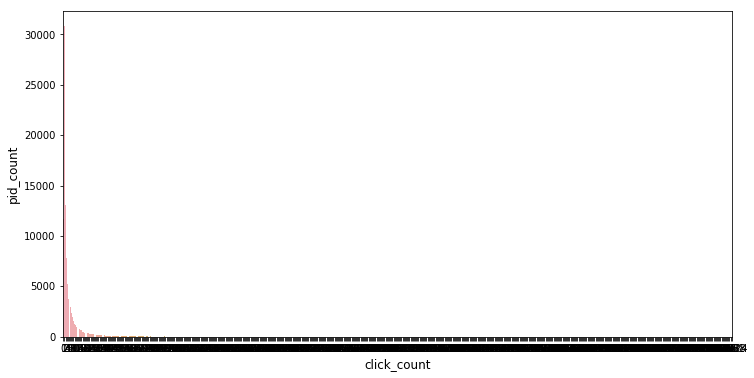

In [18]:
temp = queries_clicks.groupby('pid', as_index=False)['click_mode'].count()
pid_count = temp.groupby('click_mode')['pid'].count()

plt.figure(figsize=(12, 6))
sns.barplot(pid_count.index, pid_count.values, alpha=0.8)
plt.ylabel('pid_count', fontsize=12)
plt.xlabel('click_count', fontsize=12)
plt.show()

发现每个人的平均次数较少，所以和通常的根据用户的历史数据预测未来是否购买问题是不一样的，没必要进行滑窗统计pid的特征。 

### 特征工程

原始数据能用到的特征分为三块。
1. pid的属性（三分之一缺失）；
2. OD延伸出来的距离，角度和本身的经纬度数值信息；
3. plan里的信息。

根据ijcai-2018 植物大佬的经验，我们希望能用OD的信息来表征pid，用pid的信息表征OD，而且上面的数据探索也证明了交叉特征对于模型会有帮助，
实际在后续的验证过程中，直接乘除或者利用逻辑符编程二值特征（距离是否大于5公里和时间是否大于晚上九点，是的话为1，不是为0）并没有什么作用，
所以用xlearn里的FFM进行二分类预测，并把输出概率作为特征加入到LightGBM多分类模型里。

除了以上提到的原始信息之外，还加入了以下特征，在特征重要性分析时，还挺重要的。
1. OD的功能区表达embedding（百度这次比赛源于论文“Joint Representation Learning for Multi-Modal Transportation Recommendation”，比赛
里的话都是从论文里摘抄的，不过论文更像是推荐的召回阶段，即matching，我们做的是rank，所以我读了几篇论文后面的引文，找到了这个获取OD表达
的方法，感觉这样就不用依赖于外部数据，通过用户出行规律来划分OD的功能区，比如办公区，娱乐区，住宅区等）；
2. OD的frequency encoding，比直接类别编码好用；
3. pid上一下请求时间差，下一次请求时间差，从同样起点请求时间差，从同样终点请求时间差；
4. 同类用户出行距离的方差、均值、最大值和最小值；
5. 同类用户从同一起点，百度地图推荐交通方式的频率，比如A用户从a点搜了10次，在这10次里，交通方式2推荐了5次，那么频率就是0.5，所以这一个
特征实际上有11列；
6. 还有杂七杂八的一些特征；